In [ ]:
from actions import ActionsWorkflow, ActionsJobs, ActionsArtifacts
import LogExtractor as extractor

from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import SimpleDocTemplate, Paragraph, Table, TableStyle, Spacer, ListFlowable, ListItem
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import tempfile


## Retrieving test data and processing 

In [ ]:
repo_path = 'MagaluCloud/s3-specs'
query_size = 10


In [ ]:

workflow = ActionsWorkflow(repository=repo_path, query_size=query_size)
jobs = ActionsJobs(repo_path, workflow)

all_workflows_jobs = pd.DataFrame()

for id in workflow.df['databaseId']:
    tmp = jobs.get_jobs(id)
    all_workflows_jobs = pd.concat([all_workflows_jobs, tmp])

In [ ]:
artifacts = ActionsArtifacts(repository=repo_path)
all_tests_df = pd.DataFrame()
all_times_df = pd.DataFrame()
all_failures_df = pd.DataFrame()

for path in artifacts.paths:
    artifact = extractor.PytestArtifactLogExtractor(path)
    pytest_tests_status	, pytest_run_times, pytest_failures_errors = artifact.log_to_df()
    all_tests_df = pd.concat([all_tests_df, pytest_tests_status])
    all_times_df = pd.concat([all_times_df, pytest_run_times])
    all_failures_df = pd.concat([all_failures_df, pytest_failures_errors])

In [ ]:
# Trocar databaseId por jobId
display(all_tests_df)
display(all_times_df[all_times_df['databaseId'].notna()])
display(all_failures_df)

## Plotter

In [321]:
# Setup
error_distribution_df = all_tests_df[['category', 'status']]
error_passed_info = error_distribution_df.groupby(['status','category']).value_counts()

status_freq_df = pd.concat([error_passed_info.FAILED, error_passed_info.PASSED], axis=1).fillna(0).astype(int)
status_freq_df.columns = ['FAILED','PASSED']
status_freq_df = status_freq_df.reset_index()


In [322]:
def error_distribution_pie_chat(error_df):
    # Filter for FAILED status
    failed_df = error_df[error_df['status'] == 'FAILED']

    # Group by category and count the number of FAILED statuses
    failed_counts = failed_df.groupby('category').size().reset_index(name='count')

    # Create the pie chart
    fig = px.pie(
        failed_counts, 
        names="category",  # Use 'category' for pie slice labels
        values="count",    # Use 'count' for pie slice sizes
        title="Distribution of FAILED Tests by Category",
        color_discrete_sequence=px.colors.sequential.RdBu,
    )

    fig.update_layout(
    #   width=400,  # Set the width of the plot (in pixels)
    #  height=400,  # Set the height of the plot (in pixels)
        margin=dict(l=20, r=20, t=40, b=20)  # Adjust margins if needed
    )

    # Make the pie chart circle bigger by adjusting the marker size
    fig.update_traces(
        marker=dict(line=dict(color='white', width=2)),  # Optional: Add a white border
        textposition='inside',  # Display text inside the slices
        textinfo='percent+label'  # Show percentage and label
    )

    # Show the pie chart
    return fig

    

In [ ]:
def error_distribution_pie_chat_plt(error_df):

    plt.figure(figsize=(5, 5))
    plt.pie(
        error_passed_info['FAILED'].values,
        labels=error_passed_info['FAILED'].index.to_list(),
        autopct='%1.1f%%',
        startangle=90,
        colors=['firebrick', 'lightgreen', 'lightskyblue'],
    )
    plt.legend(title="Error Types", loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.title('Failure Distribution')
    plt.tight_layout()

    return fig

In [ ]:
def plot_category_errors_bar(df):
    # Calculate the frequency of errors per category
    error_freq_df = df.groupby(['category', 'error']).size().reset_index(name='frequency')

    # Create the bar plot
    fig = px.bar(
        error_freq_df, 
        x="category", 
        y="frequency", 
        color="error",  # Use a discrete color sequence
        color_discrete_sequence=px.colors.sequential.RdBu,
        title="Frequency of Errors by Category",
        labels={'frequency': 'Frequency of Errors', 'category': 'Category'},
    )

    # Adjust layout to control bar width
    fig.update_layout(
        xaxis_title="Category",
        yaxis_title="Frequency of Errors",
        barmode='stack',  
        bargroupgap=0.1,  
        width=600,
        margin=dict(l=20, r=20, t=40, b=20)  
    )

    # Show the plot
    return fig

In [325]:
def categories_failures_passied_rate(status_freq_df):
    # Calcular totais e percentuais
    status_freq_df['Total'] = status_freq_df['PASSED'] + status_freq_df['FAILED']
    status_freq_df['PASSED_pct'] = (status_freq_df['PASSED'] / status_freq_df['Total']) * 100
    status_freq_df['FAILED_pct'] = (status_freq_df['FAILED'] / status_freq_df['Total']) * 100

    # Transformar dados para formato longo
    status_freq_long = status_freq_df.melt(
        id_vars=['category'], 
        value_vars=['PASSED_pct', 'FAILED_pct'], 
        var_name='Status', 
        value_name='Percentage'
    )

    # Criar coluna com valores reais correspondentes
    status_freq_long['Real Value'] = status_freq_long.apply(
        lambda row: status_freq_df.loc[status_freq_df['category'] == row['category'], row['Status'].replace('_pct', '')].values[0], 
        axis=1
    )

    # Criar gráfico
    fig = px.bar(
        status_freq_long, 
        x="category", 
        y="Percentage", 
        color="Status", 
        barmode='stack', 
        title="Proportion of Passed/Failed (%) with Real Values Displayed",
        labels={'Percentage': 'Percentage'},
        text=status_freq_long["Real Value"]  # Exibir valores reais nas barras
    )

    # Ajustar layout para exibir os valores dentro das barras
    fig.update_traces(texttemplate='%{text}', textposition='inside')
    fig.update_yaxes(title='Percentage')
    fig.update_xaxes(title='Category')

    return fig

## Creating pdf

In [ ]:
pytest_tests_status.index.unique()

In [ ]:
pytest_run_times.index.unique()

In [ ]:
# Generate a tuple with the category name and the summed up values of all index of said class
def get_time(metric):
    return pd.Series(dict(map(lambda t, x: (x, pytest_run_times.loc[pytest_run_times.index == t, metric].sum()), pytest_tests_status.index.unique(), pytest_tests_status.category.unique())))

total_times = get_time('total')
avg_time_test = get_time('avg')
min_test_time  = get_time('min')

total_nums = pytest_tests_status['category'].value_counts()
total_passed = pytest_tests_status[pytest_tests_status.index.values != 'PASSED'].set_index('category').index.value_counts()
time_count_df = pd.concat([total_passed, total_nums - total_passed, total_nums, min_test_time, avg_time_test, total_times], axis=1)
time_count_df.columns = ['num_passed', 'num_failed', 'total_runs', 'min_test_time', 'avg_test_time', 'total_duration']

report_df = pd.DataFrame()
report_df['name'] = pytest_tests_status['category'].unique()
report_df = report_df.set_index('name')

report_df = pd.concat([report_df, time_count_df], axis=1)
report_df

In [ ]:
# Generate tuple with error values 
errors_df = all_failures_df
errors_df

Blocos que vão existir

Topo: Contendo Informações básicas do relatório e se possível alguns campos em branco e também a data de quando o código foi executado

Texto: Informações gerais do número de acertos e erros

Tabela: Contem o dataframe report_df, mas estilizado

Gráficos: fica pra dps

In [ ]:
df = report_df.reset_index().round(2)
# Function to create PDF
def create_pdf(df, df_errors):
    # A4 size dimensions
    width, height = A4

    # Set 10% margin
    margin = 0.1 * width

    # Create PDF with margins
    doc = SimpleDocTemplate("report_v0.pdf", pagesize=A4,
                            leftMargin=margin, rightMargin=margin, topMargin=0.1*height, bottomMargin=0.1*height)

    # Styles
    styles = getSampleStyleSheet()
    heading_style = styles['Heading1']
    normal_style = styles['Normal']
    normal_style.alignment = 0  # 0 for left alignment

    bold_style = ParagraphStyle(
        name="Bold",
        parent=normal_style,
        fontName="Helvetica-Bold",
        fontSize=12
    )

    # Create the story (content) for the PDF
    story = []

    # Add title with fields
    story.extend(create_title(heading_style,normal_style))

    # Add each section to the story
    story.extend(create_execution_summary(df, normal_style, bold_style))
    story.extend(create_detailed_results(df, normal_style, bold_style, width, margin))
    story.extend(create_errors_summary(df_errors, normal_style, bold_style, width, margin))

    # Build PDF
    doc.build(story)

# Function to create the title zone and text on the pdf
def create_title(heading_style, normal_style):
    # Initialize the story list
    story = []

    # Get current date and time
    agora = datetime.now()
    horario_dia = agora.strftime("%d/%m/%Y %H:%M:%S")

    # Create the title
    title_text = "Sumário de Resultados dos Testes"
    title_paragraph = Paragraph(f"<b>{title_text}</b>", heading_style)

    # Create the formatted text for the execution date on the right side
    right_date_style = ParagraphStyle(
        "RightDateStyle", parent=normal_style, alignment=2, fontSize=10
    )
    date_paragraph = Paragraph(horario_dia, right_date_style)

    # Add title and date to the story as separate elements
    story.append(title_paragraph)
    story.append(date_paragraph)

    # Create the formatted text for the execution date, system version, and environment
    execution_paragraph = Paragraph(f"Data da Execução: ", normal_style)
    version_paragraph = Paragraph("Versão do Sistema: ", normal_style)
    environment_paragraph = Paragraph("Ambiente: ", normal_style)

    # Add other paragraphs to the story
    story.append(execution_paragraph)
    story.append(Spacer(1, 12))  # Spacer between execution and version
    story.append(version_paragraph)
    story.append(Spacer(1, 12))  # Spacer between version and environment
    story.append(environment_paragraph)

    story.append(Spacer(1, 24))  # Add space at the end

    # Return the complete story
    return story

# Function to create execution summary table with bullet points
def create_execution_summary(df, normal_style, bold_style):
    story = []
    story.append(Paragraph("Resumo Geral", bold_style))
    story.append(Spacer(1, 6))

    # Criando a lista de resumo corretamente
    summary_data = {
        'Total de Testes:': df['total_runs'].sum(),
        'Testes Bem-Sucedidos:': df['num_passed'].sum(),
        'Testes com Falha:': df['num_failed'].sum(),
        'Tempo Mínimo de Execução:': f"{df['min_test_time'].min():.2f} s",
        'Tempo Médio de Execução:': f"{df['avg_test_time'].mean():.2f} s",
        'Duração Total dos Testes:': f"{df['total_duration'].sum():.2f} s"
    }

    # Criando a lista com bullet points
    bullet_points = [
        ListItem(Paragraph(f"<b>{key}</b> {value}", normal_style), leftIndent=20, spaceAfter=6)
        for key, value in summary_data.items()
    ]

    # Criando o ListFlowable
    list_flowable = ListFlowable(bullet_points, bulletType='bullet', leftIndent=20)

    # Adicionando ao relatório
    story.append(list_flowable)
    story.append(Spacer(1, 24))

    return story

# Function to create detailed results table
def create_detailed_results(df, normal_style, bold_style, width, margin):
    story = []
    story.append(Paragraph("Detalhamento dos Testes", bold_style))
    story.append(Spacer(1, 12))
    df_renamed = df.copy()  # Create a copy of the DataFrame
    df_renamed.columns = [
        'Categoria de Teste', 
        'Testes Bem-Sucedidos', 
        'Falhas', 
        'Execuções', 
        'Tempo Mínimo de Execução', 
        'Tempo Médio', 
        'Duração Total'
    ]


    # Dropping the specified columns
    df_renamed = df_renamed.drop(columns=['Testes Bem-Sucedidos', 'Tempo Mínimo de Execução'])

    df_renamed['Tempo Médio'] = df_renamed['Tempo Médio'].astype(str) + ' sec'
    df_renamed['Duração Total'] = df_renamed['Duração Total'].astype(str) + ' sec'

    # Prepare the detailed data for the table
    detailed_tests_data = [df_renamed.columns.tolist()]  # Add header
    detailed_tests_data.extend(
        [[Paragraph(str(value), normal_style) for value in row] for row in df_renamed.values.tolist()]
    )

    # Calculate available width after applying margins
    available_width = width - 2 * margin  # Subtracting left and right margins

    # Define column proportions
    proportions = [0.3, 0.15, 0.15, 0.15, 0.2]  # Example proportions

    total_proportion = sum(proportions)
    if total_proportion > 1:
        proportions = [p / total_proportion for p in proportions]  # Scale proportions to fit within 1

    # Calculate column widths based on the available width
    col_widths = [available_width * p for p in proportions]

    # Create the table
    detailed_table = Table(detailed_tests_data, colWidths=col_widths)
    detailed_table.setStyle(TableStyle([('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                                        ('GRID', (0, 0), (-1, -1), 0.5, colors.black)]))
    story.append(detailed_table)
    story.append(Spacer(1, 24))

    return story


def create_errors_summary(df, normal_style, bold_style, width, margin):
    """
    Creates a summary of errors in a PDF document.

    :param df: DataFrame containing error data.
    :param normal_style: Style for normal text.
    :param bold_style: Style for bold text.
    :param width: Width of the page.
    :param margin: Margin size.
    :return: A list of elements to be added to the PDF.
    """
    story = []
    story.append(Paragraph("Resumo dos Erros", bold_style))
    story.append(Spacer(1, 12))

    # Create a copy of the DataFrame and reset the index
    df_copy = df.copy().reset_index()
    df_copy.columns = [
        'Nome',
        'Status',
        'Categoria do Teste',
        'Tipo de erro',
        'Detalhes do erro (100 caracteres)',
        'JobId',
    ]

    df_copy = df_copy.drop('Detalhes do erro (100 caracteres)', axis=1)
    display(df_copy)


    # Prepare the detailed data for the table
    detailed_tests_data = [[Paragraph(str(value), normal_style) for value in df_copy.columns.tolist()]]  # Add header
    detailed_tests_data.extend(
        [[Paragraph(str(value), normal_style) for value in row] for row in df_copy.values.tolist()]
    )

    # Calculate available width after applying margins
    available_width = width - 2 * margin  # Subtracting left and right margins

    # Define column proportions
    proportions = [0.3, 0.15, 0.15, 0.15, 0.2, 0.1]  # Example proportions

    # Calculate column widths based on the available width
    col_widths = [available_width * p for p in proportions]

    # Create the table
    detailed_table = Table(detailed_tests_data, colWidths=col_widths)
    detailed_table.setStyle(TableStyle([
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),  # Center-align all cells
        ('GRID', (0, 0), (-1, -1), 0.5, colors.black),  # Add grid lines
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),  # Bold header font
    ]))
    story.append(detailed_table)
    story.append(Spacer(1, 24))

    return story

def create_graphics(df, df_errors):
    
    

# Gerar o PDF
create_pdf(df, errors_df)


## Plotting

### Error distribution (Pie chart)

In [ ]:
error_distribution_df = all_tests_df[['category', 'status']]
error_passed_info = error_distribution_df.groupby(['status','category']).value_counts()

status_freq_df = pd.concat([error_passed_info.FAILED, error_passed_info.PASSED], axis=1).fillna(0).astype(int)
status_freq_df.columns = ['FAILED','PASSED']
status_freq_df = status_freq_df.reset_index()


In [ ]:
def error_distribution_pie_chat(error_df):
    # Filter for FAILED status
    failed_df = error_df[error_df['status'] == 'FAILED']

    # Group by category and count the number of FAILED statuses
    failed_counts = failed_df.groupby('category').size().reset_index(name='count')

    # Create the pie chart
    fig = px.pie(
        failed_counts, 
        names="category",  # Use 'category' for pie slice labels
        values="count",    # Use 'count' for pie slice sizes
        title="Distribution of FAILED Tests by Category",
        color_discrete_sequence=px.colors.sequential.RdBu,
    )

    fig.update_layout(
    #   width=400,  # Set the width of the plot (in pixels)
    #  height=400,  # Set the height of the plot (in pixels)
        margin=dict(l=20, r=20, t=40, b=20)  # Adjust margins if needed
    )

    # Make the pie chart circle bigger by adjusting the marker size
    fig.update_traces(
        marker=dict(line=dict(color='white', width=2)),  # Optional: Add a white border
        textposition='inside',  # Display text inside the slices
        textinfo='percent+label'  # Show percentage and label
    )

    # Show the pie chart
    fig.show()

    

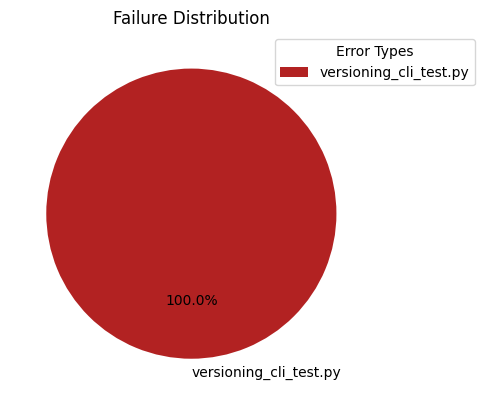

In [315]:
def error_distribution_pie_chat_plt(error_df):

    plt.figure(figsize=(5, 5))
    plt.pie(
        error_passed_info['FAILED'].values,
        labels=error_passed_info['FAILED'].index.to_list(),
        autopct='%1.1f%%',
        startangle=90,
        colors=['firebrick', 'lightgreen', 'lightskyblue'],
    )
    plt.legend(title="Error Types", loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.title('Failure Distribution')
    plt.tight_layout()
    plt.show()



### Proportion of Passed/Failed (%) with Real Values Displayed

In [ ]:

# Calcular totais e percentuais
status_freq_df['Total'] = status_freq_df['PASSED'] + status_freq_df['FAILED']
status_freq_df['PASSED_pct'] = (status_freq_df['PASSED'] / status_freq_df['Total']) * 100
status_freq_df['FAILED_pct'] = (status_freq_df['FAILED'] / status_freq_df['Total']) * 100

# Transformar dados para formato longo
status_freq_long = status_freq_df.melt(
    id_vars=['category'], 
    value_vars=['PASSED_pct', 'FAILED_pct'], 
    var_name='Status', 
    value_name='Percentage'
)

# Criar coluna com valores reais correspondentes
status_freq_long['Real Value'] = status_freq_long.apply(
    lambda row: status_freq_df.loc[status_freq_df['category'] == row['category'], row['Status'].replace('_pct', '')].values[0], 
    axis=1
)

# Criar gráfico
fig = px.bar(
    status_freq_long, 
    x="category", 
    y="Percentage", 
    color="Status", 
    barmode='stack', 
    title="Proportion of Passed/Failed (%) with Real Values Displayed",
    labels={'Percentage': 'Percentage'},
    text=status_freq_long["Real Value"]  # Exibir valores reais nas barras
)

# Ajustar layout para exibir os valores dentro das barras
fig.update_traces(texttemplate='%{text}', textposition='inside')
fig.update_yaxes(title='Percentage')
fig.update_xaxes(title='Category')

fig.show()


### Error type rate


In [ ]:
def plot_category_errors_bar(df):
    # Calculate the frequency of errors per category
    error_freq_df = df.groupby(['category', 'error']).size().reset_index(name='frequency')

    # Create the bar plot
    fig = px.bar(
        error_freq_df, 
        x="category", 
        y="frequency", 
        color="error",  # Use a discrete color sequence
        color_discrete_sequence=px.colors.sequential.RdBu,
        title="Frequency of Errors by Category",
        labels={'frequency': 'Frequency of Errors', 'category': 'Category'},
    )

    # Adjust layout to control bar width
    fig.update_layout(
        xaxis_title="Category",
        yaxis_title="Frequency of Errors",
        barmode='stack',  
        bargroupgap=0.1,  
        width=600,
        margin=dict(l=20, r=20, t=40, b=20)  
    )

    # Show the plot
    fig.show()